# Visual-language assistant with LLaVA and OpenVINO

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/llava-multimodal-chatbot/llava-multimodal-chatbot.ipynb) to get the most updated version of the notebook. This branch is deprecated.

[LLaVA](https://llava-vl.github.io) (Large Language and Vision Assistant) is large multimodal model that aims to develop a general-purpose visual assistant that can follow both language and image instructions to complete various real-world tasks. The idea is to combine the power of large language models (LLMs) with vision encoders like CLIP to create an end-to-end trained neural assistant that understands and acts upon multimodal instructions.

In the field of artificial intelligence, the goal is to create a versatile assistant capable of understanding and executing tasks based on both visual and language inputs. Current approaches often rely on large vision models that solve tasks independently, with language only used to describe image content. While effective, these models have fixed interfaces with limited interactivity and adaptability to user instructions. On the other hand, large language models (LLMs) have shown promise as a universal interface for general-purpose assistants. By explicitly representing various task instructions in language, these models can be guided to switch and solve different tasks. To extend this capability to the multimodal domain, the [LLaVA paper](https://arxiv.org/abs/2304.08485) introduces  `visual instruction-tuning, a novel approach to building a general-purpose visual assistant. 

In this tutorial we consider how to use LLaVA model to build multimodal chatbot. For demonstration purposes we will use [LLaVA-Lightning-MPT-7B-preview](https://huggingface.co/liuhaotian/LLaVA-Lightning-MPT-7B-preview) model for conversion, similar steps required to run other models from [LLaVA Model Zoo](https://github.com/haotian-liu/LLaVA/blob/main/docs/MODEL_ZOO.md).

The tutorial consists from following steps:

- Install prerequisites
- Prepare input processor and tokenizer
- Download original model
- Compress model weights to 4 and 8 bits using NNCF
- Convert model to OpenVINO Intermediate Representation (IR) format
- Prepare OpenVINO-based inference pipeline
- Run OpenVINO model


#### Table of contents:

- [About model](#About-model)
- [Prerequisites](#Prerequisites)
- [Build model tokenizer and image processor](#Build-model-tokenizer-and-image-processor)
- [Build model and convert it to OpenVINO IR format](#Build-model-and-convert-it-to-OpenVINO-IR-format)
    - [Prepare helpers for model conversion](#Prepare-helpers-for-model-conversion)
    - [Convert and Optimize Model](#Convert-and-Optimize-Model)
        - [Instantiate PyTorch model $\Uparrow$(#Table-of-content:)](#Instantiate-PyTorch-model-\Uparrow(#Table-of-content:))
        - [Compress Model weights to 4 and 8 bits using NNCF $\Uparrow$(#Table-of-content:)](#Compress-Model-weights-to-4-and-8-bits-using-NNCF-\Uparrow(#Table-of-content:))
        - [Convert model to OpenVINO IR format $\Uparrow$(#Table-of-content:)](#Convert-model-to-OpenVINO-IR-format-\Uparrow(#Table-of-content:))
- [Prepare OpenVINO based inference pipeline](#Prepare-OpenVINO-based-inference-pipeline)
- [Run model inference](#Run-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Load OpenVINO model](#Load-OpenVINO-model)
    - [Prepare input data](#Prepare-input-data)
    - [Test model inference](#Test-model-inference)
- [Interactive demo](#Interactive-demo)



## About model
[back to top ⬆️](#Table-of-contents:)

 LLaVA connects pre-trained [CLIP ViT-L/14](https://openai.com/research/clip) visual encoder and large language model like Vicuna, LLaMa v2 or MPT, using a simple projection matrix

![vlp_matrix.png](https://llava-vl.github.io/images/llava_arch.png)

Model training procedure consists of 2 stages:

* Stage 1: Pre-training for Feature Alignment. Only the projection matrix is updated, based on a subset of CC3M.
* Stage 2: Fine-tuning End-to-End.. Both the projection matrix and LLM are updated for two different use scenarios:
  - Visual Chat: LLaVA is fine-tuned on our generated multimodal instruction-following data for daily user-oriented applications.
  - Science QA: LLaVA is fine-tuned on this multimodal reasoning dataset for the science domain.

More details about model can be found in original [project web-page](https://llava-vl.github.io/), [paper](https://arxiv.org/abs/2304.08485) and [repo](https://github.com/haotian-liu/LLaVA).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required dependencies

In [1]:
import sys

%pip install -q "torch>=2.1.0" "torchvision" "torchaudio" --index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2023.2.0" "nncf>=2.7.0"  "sentencepiece" "tokenizers>=0.12.1" "transformers>=4.37.2" "gradio" "einops"

Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

repo_dir = Path("LLaVA")

if not repo_dir.exists():
    !git clone https://github.com/haotian-liu/LLaVA.git

sys.path.insert(0, str(repo_dir.resolve()))

## Build model tokenizer and image processor
[back to top ⬆️](#Table-of-contents:)

For starting work with model, we need understand how to prepare input data first. As it is already discussed before, LLaVA is multimodal model that accepts input user instructions in text format and image for analysis. In the same time, LLaVA is combination of 2 fundamental pretrained models for text and image processing, CLIP and MPT, each of them has own approach for preparing data - tokenization for input text and preprocessing for input image. LLaVA reuses these steps with small adoption: introduced special tokens that serves for specification of image location in the text that should be injected in provided user instruction.

In [3]:
from transformers import AutoTokenizer, AutoConfig, CLIPImageProcessor
from llava.model.language_model.llava_mpt import LlavaMptForCausalLM

model_id = "liuhaotian/LLaVA-Lightning-MPT-7B-preview"

config = AutoConfig.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
image_processor = CLIPImageProcessor.from_pretrained(config.mm_vision_tower)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from llava.constants import (
    DEFAULT_IMAGE_PATCH_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    DEFAULT_IMAGE_TOKEN
)

mm_use_im_start_end = getattr(config, "mm_use_im_start_end", False)
mm_use_im_patch_token = getattr(config, "mm_use_im_patch_token", True)
if mm_use_im_patch_token:
    tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens(
        [DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True
    )

if hasattr(config, "max_sequence_length"):
    context_len = config.max_sequence_length
else:
    context_len = 2048

## Build model and convert it to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

LLaVA is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the [documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

The inference flow has difference on first step and for the next. On the first step, model accept preprocessed input instruction and image, that transformed to the unified embedding space using `token_embedding` and `image_encoder` models, after that LLM-based part of model runs on input embeddings to predict probability of next generated tokens. On the next step, model accepts only next token id selected based on sampling strategy and cached attention key and values.  Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation).

### Prepare helpers for model conversion
[back to top ⬆️](#Table-of-contents:)

The code below prepares function for converting LLaVA model to OpenVINO Intermediate Representation format. It splits model on parts described above, prepare example inputs for each part and convert each part using [OpenVINO Model Conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model). `ov.convert_model` function accepts PyTorch model instance and returns `ov.Model` object that represent model in OpenVINO format. It is ready to use for loading on device using `ov.compile_model` or can be saved on disk using `ov.save_model`.

In [5]:
from functools import wraps
import gc
import warnings
import torch
import openvino as ov
import nncf
from typing import Optional, Tuple, List
import torch.nn.functional as F

warnings.filterwarnings('ignore')


class ModelWrapper(torch.nn.Module):
    """
    Model wrapper class for export for spliting original forward logic on preparing multimodal data and inference using it.
    That allows us to sperate image encoder and token embeddings model from general flow. 
    """
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
    ):
        outputs = self.model.transformer(
            input_ids=input_ids,
            inputs_embeds=inputs_embeds,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            return_dict=True,
            output_attentions=False,
            output_hidden_states=False,
            use_cache=True,
        )
        logits = F.linear(
            outputs.last_hidden_state.to(self.model.transformer.wte.weight.device),
            self.model.transformer.wte.weight.to(outputs.last_hidden_state.dtype),
        )

        return (logits, tuple(outputs.past_key_values))

    
def patch_model_forward(model):
    """
    Helper function for patching model forward for model with past. 
    It makes model more convinient for export to TorchScript format avoiding limitation 
    that list of tensors can not be correctly traced as model input
    """
    
    orig_forward = model.forward

    @wraps(orig_forward)
    def ts_patched_forward(
        input_ids: torch.Tensor,
        past_key_values: Tuple[Tuple[torch.Tensor]],
        attention_mask: torch.LongTensor,
    ):
        pkv_list = list(past_key_values)
        outs = orig_forward(input_ids=input_ids, past_key_values=pkv_list, attention_mask=attention_mask,)
        return outs

    model.forward = ts_patched_forward
    return model


def flattenize_inputs(inputs):
    """
    Helper function for making nested inputs flattens
    """
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

def postprocess_converted_model(ov_model, example_input=None, input_names=None, output_names=None, dynamic_shapes=None):
    """
    Helper function for appling postprocessing on converted model with updating input names, shapes and output names
    acording to requested specification
    """
    flatten_example_inputs = flattenize_inputs(example_input) if example_input else []
    
    if input_names:
        for inp_name, m_input, input_data in zip(input_names, ov_model.inputs, flatten_example_inputs):
            input_node = m_input.get_node()
            if input_node.element_type == ov.Type.dynamic:
                m_input.get_node().set_element_type(ov.Type.f32)
            shape = list(input_data.shape)
            if dynamic_shapes is not None and inp_name in dynamic_shapes:
                for k in dynamic_shapes[inp_name]:
                    shape[k] = -1
            input_node.set_partial_shape(ov.PartialShape(shape))
            m_input.get_tensor().set_names({inp_name})
    
    if output_names:
        for out, out_name in zip(ov_model.outputs, output_names):
            out.get_tensor().set_names({out_name})
    ov_model.validate_nodes_and_infer_types()
    return ov_model


def convert_llava_mpt(pt_model: torch.nn.Module, model_path: Path,
                      image_encoder_wc_parameters: Optional[dict] = None,
                      llava_wc_parameters: Optional[dict] = None):
    """
    LLaVA MPT model conversion function

    Params:
      pt_model: PyTorch model
      model_path: path for saving model
    Returns:
      None
    """
    ov_out_path = Path(model_path)
    pt_model.config.save_pretrained(ov_out_path)
    pt_model.config.use_cache = True
    pt_model.config.torchscript = True
    first_stage_model_path = ov_out_path / "llava_input_embed.xml"
    image_encoder_path = ov_out_path / "image_encoder.xml"
    token_embedding_model_path = ov_out_path / "token_embed.xml"
    second_stage_model_path = ov_out_path / "llava_with_past.xml"
    if not image_encoder_path.exists():
        model.forward = model.encode_images
        ov_model = ov.convert_model(
            model, example_input=torch.zeros((1, 3, 224, 224)), input=[(-1, 3, 224, 224)]
        )
        if image_encoder_wc_parameters is not None:
            print("Applying weight compression to image encoder")
            ov_model = nncf.compress_weights(ov_model, **image_encoder_wc_parameters)
        ov.save_model(ov_model, image_encoder_path)
        cleanup_torchscript_cache()
        del ov_model
        gc.collect()
        print("Image Encoder model successfully converted")

    if not token_embedding_model_path.exists():
        model.forward = model.get_model().embed_tokens
        ov_model = ov.convert_model(
            model, example_input=torch.ones((1, 10), dtype=torch.long)
        )
        ov.save_model(ov_model, token_embedding_model_path)
        cleanup_torchscript_cache()
        del ov_model
        gc.collect()
        print("Token Embedding model successfully converted")

    if first_stage_model_path.exists() and second_stage_model_path.exists():
        print("LLaVA model successfully converted")
        del pt_model
        return
    model_wrap = ModelWrapper(model)
    example_input_first_stage = {
        "inputs_embeds": torch.zeros((1, 307, 4096)),
        "attention_mask": torch.ones((1, 307), dtype=torch.long),
    }
    outs = model_wrap(**example_input_first_stage)
    inputs = ["input_ids"]
    outputs = ["logits"]
    dynamic_shapes = {"input_ids": {1: "seq_len"}, "attention_mask": {1: "seq_len"}}
    for idx in range(len(outs[1])):
        inputs.extend([f"past_key_values.{idx}.key", f"past_key_values.{idx}.value"])
        dynamic_shapes[inputs[-1]] = {2: "past_sequence + sequence"}
        dynamic_shapes[inputs[-2]] = {2: "past_sequence + sequence"}
        outputs.extend([f"present.{idx}.key", f"present.{idx}.value"])

    inputs.extend(["attention_mask"])
    if not first_stage_model_path.exists():
        ov_model = ov.convert_model(
            model_wrap, example_input=example_input_first_stage
        )
        ov_model = postprocess_converted_model(ov_model, output_names=outputs)
        if llava_wc_parameters is not None:
            print("Applying weight compression to first stage LLava model")
            ov_model = nncf.compress_weights(ov_model, **llava_wc_parameters)
        ov.save_model(ov_model, first_stage_model_path)
        cleanup_torchscript_cache()
        del ov_model
        gc.collect()
            

    if not second_stage_model_path.exists():
        model_wrap = patch_model_forward(model_wrap)
        example_input_second_stage = {
            "input_ids": torch.ones((1, 1), dtype=torch.long),
            "past_key_values": outs[1],
            "attention_mask": torch.ones((1, outs[1][-1][-1].shape[-2] + 1), dtype=torch.long)
        }
        ov_model = ov.convert_model(model_wrap, example_input=example_input_second_stage)
        ov_model = postprocess_converted_model(
            ov_model, 
            example_input=example_input_second_stage.values(), 
            input_names=inputs, 
            output_names=outputs, 
            dynamic_shapes=dynamic_shapes
        )
        if llava_wc_parameters is not None:
            print("Applying weight compression to second stage LLava model")
            ov_model = nncf.compress_weights(ov_model, **llava_wc_parameters)
        ov.save_model(ov_model, second_stage_model_path)
        cleanup_torchscript_cache()
        del ov_model
        gc.collect()
    print("LLaVA model successfully converted")
    del model_wrap
    del pt_model

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


### Convert and Optimize Model
[back to top ⬆️](#Table-of-contents:)

Our model conversion and optimization consist of following steps:
1. Download original PyTorch model.
2. Compress model weights using NNCF
3. Convert model to OpenVINO format and save it on disk.

Let's consider each step more deeply.

#### Instantiate PyTorch model [$\Uparrow$](#Table-of-content:)
[back to top ⬆️](#Table-of-contents:)

For creating PyTorch model we should use `from_pretrained` method of `LlavaMPTForCausalLM` model class. Model weights will be downloaded from [HuggingFace hub](https://huggingface.co/models) during first run. It may takes some time and requires at least 13 Gb free space on disk.

#### Compress Model weights to 4 and 8 bits using NNCF [$\Uparrow$](#Table-of-content:)
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

>**Note**: There is no speedup for INT4 compressed models on dGPU.

#### Convert model to OpenVINO IR format [$\Uparrow$](#Table-of-content:)
[back to top ⬆️](#Table-of-contents:)

Convert model to OpenVINO format using conversion helper function defined above.

Please select below whether you would like to run INT4 weight compression instead of INT8 weight compression.

In [6]:
import ipywidgets as widgets

compression_mode = widgets.Dropdown(
    options=['INT4', 'INT8'],
    value='INT4',
    description='Compression mode:',
    disabled=False,
)

compression_mode

Dropdown(description='Compression mode:', options=('INT4', 'INT8'), value='INT4')

In [7]:
if compression_mode.value == 'INT4':
    compressed_model_dir = Path("llava-mpt/INT4_compressed_weights")
    llava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT4_ASYM, group_size=128, ratio=0.8)
else:
    compressed_model_dir = Path("llava-mpt/INT8_compressed_weights")
    llava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

if not compressed_model_dir.exists():
    compressed_model_dir.mkdir(exist_ok=True, parents=True)
    config.save_pretrained(compressed_model_dir)
    model = LlavaMptForCausalLM.from_pretrained(model_id)
    vision_tower = model.get_vision_tower()
    if not vision_tower.is_loaded:
        vision_tower.load_model()

    if mm_use_im_start_end:
        model.resize_token_embeddings(len(tokenizer))

    model.eval()
    with torch.no_grad():
        convert_llava_mpt(model, compressed_model_dir,
                          image_encoder_wc_parameters=dict(mode=nncf.CompressWeightsMode.INT8),
                          llava_wc_parameters=llava_wc_parameters)
    del model
    gc.collect();

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Applying weight compression to image encoder
INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 100% (139 / 139)          | 100% (139 / 139)                  |
+--------------+---------------------------+-----------------------------------+


Output()

Image Encoder model successfully converted
Token Embedding model successfully converted
Applying weight compression to first stage LLava model


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 23% (38 / 129)            | 21% (37 / 128)                    |
+--------------+---------------------------+-----------------------------------+
| 4            | 77% (91 / 129)            | 79% (91 / 128)                    |
+--------------+---------------------------+-----------------------------------+


Output()

Applying weight compression to second stage LLava model


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+---------------------------+-----------------------------------+
| Num bits (N) | % all parameters (layers) |    % ratio-defining parameters    |
|              |                           |             (layers)              |
+==============+===========================+===================================+
| 8            | 26% (39 / 130)            | 21% (37 / 128)                    |
+--------------+---------------------------+-----------------------------------+
| 4            | 74% (91 / 130)            | 79% (91 / 128)                    |
+--------------+---------------------------+-----------------------------------+


Output()

LLaVA model successfully converted


## Prepare OpenVINO based inference pipeline
[back to top ⬆️](#Table-of-contents:)

`OVLlavaMPTForCausalLM` class provides ease-to-use interface for using model in generation scenario. It is based on `transformers.generation.GenerationMixin` that gives us opportunity to reuse all reach capabilities for generation implemented in HuggingFace Transformers library. More details about this interface can be found in [HuggingFace documentation](https://huggingface.co/docs/transformers/main_classes/text_generation).


In [8]:
from transformers.generation import GenerationConfig, GenerationMixin
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers import AutoConfig
import numpy as np
import torch


class OVLlavaMPTForCausalLM(GenerationMixin):
    def __init__(self, core, model_dir, device):
        self.image_encoder = core.compile_model(model_dir / "image_encoder.xml", device)
        self.token_embed = core.compile_model(model_dir / "token_embed.xml", device)
        self.model = core.read_model(model_dir / "llava_with_past.xml")
        self.model_input_embed = core.compile_model(
            model_dir / "llava_input_embed.xml", device
        )
        self.input_names = {
            key.get_any_name(): idx for idx, key in enumerate(self.model.inputs)
        }
        self.output_names = {
            key.get_any_name(): idx for idx, key in enumerate(self.model.outputs)
        }
        self.key_value_input_names = [
            key for key in self.input_names if "key_values" in key
        ]
        self.key_value_output_names = [
            key for key in self.output_names if "present" in key
        ]
        compiled_model = core.compile_model(self.model, device)
        self.request = compiled_model.create_infer_request()
        self.config = AutoConfig.from_pretrained(model_dir)
        self.generation_config = GenerationConfig.from_model_config(config)
        self.main_input_name = "input_ids"
        self.device = torch.device("cpu")
        self.num_pkv = 2

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""
        return True

    def __call__(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        prefix_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        return self.forward(
            input_ids, images, attention_mask, prefix_mask, past_key_values
        )

    def forward(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        prefix_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        """General inference method"""
        inputs = {}
        if past_key_values is not None:
            # Flatten the past_key_values
            attention_mask = torch.ones(
                (input_ids.shape[0], past_key_values[-1][-1].shape[-2] + 1),
                dtype=input_ids.dtype,
            )
            past_key_values = tuple(
                past_key_value
                for pkv_per_layer in past_key_values
                for past_key_value in pkv_per_layer
            )
            # Add the past_key_values to the decoder inputs
            inputs = dict(zip(self.key_value_input_names, past_key_values))

        else:
            return self.forward_with_image(input_ids, images, attention_mask)
        inputs["input_ids"] = np.array(input_ids)

        if "attention_mask" in self.input_names:
            inputs["attention_mask"] = np.array(attention_mask)

        # Run inference
        self.request.start_async(inputs, share_inputs=True)
        self.request.wait()

        logits = torch.from_numpy(self.request.get_tensor("logits").data)

        # Tuple of length equal to : number of layer * number of past_key_value per decoder layer (2 corresponds to the self-attention layer)
        past_key_values = tuple(
            self.request.get_tensor(key).data for key in self.key_value_output_names
        )
        # Tuple of tuple of length `n_layers`, with each tuple of length equal to 2 (k/v of self-attention)

        past_key_values = tuple(
            past_key_values[i : i + self.num_pkv]
            for i in range(0, len(past_key_values), self.num_pkv)
        )
        return CausalLMOutputWithPast(logits=logits, past_key_values=past_key_values)

    def forward_with_image(self, input_ids, images, attention_mask):
        """First step inference method, that resolves multimodal data"""
        input_embed, attention_mask = self.prepare_multimodal_input(
            input_ids, images, attention_mask
        )
        outs = self.model_input_embed([input_embed, attention_mask])
        logits = outs[0]
        pkv = list(outs.values())[1:]
        pkv = tuple(pkv[i : i + self.num_pkv] for i in range(0, len(pkv), self.num_pkv))
        return CausalLMOutputWithPast(
            logits=torch.from_numpy(logits), past_key_values=pkv
        )

    def prepare_multimodal_input(self, input_ids, images, attention_mask):
        """Preprocessing function for embedding multimodal data"""
        image_features = []
        if images is not None:
            image_features = self.image_encoder(images)[0]

        new_input_embeds = []
        cur_image_idx = 0
        for batch_idx, cur_input_ids in enumerate(input_ids):
            if (cur_input_ids == IMAGE_TOKEN_INDEX).sum() == 0:
                # multimodal LLM, but the current sample is not multimodal
                cur_input_embeds = torch.from_numpy(self.token_embed(cur_input_ids.unsqueeze(0))[0][0])
                new_input_embeds.append(cur_input_embeds)
                cur_image_idx += 1
                continue
            image_token_indices = torch.where(cur_input_ids == IMAGE_TOKEN_INDEX)[0]
            cur_new_input_embeds = []
            while image_token_indices.numel() > 0:
                cur_image_features = image_features[cur_image_idx]
                image_token_start = image_token_indices[0]
                if getattr(self.config, "tune_mm_mlp_adapter", False) and getattr(
                    self.config, "mm_use_im_start_end", False
                ):
                    embd = self.token_embed(cur_input_ids[: image_token_start - 1].unsqueeze(0))[0][0]
                    cur_new_input_embeds.append(embd)
                    embd = self.token_embed(cur_input_ids[image_token_start - 1 : image_token_start].unsqueeze(0))[0][0]
                    cur_new_input_embeds.append(embd)
                    cur_new_input_embeds.append(cur_image_features)
                    embd = self.token_embed(cur_input_ids[image_token_start + 1 : image_token_start + 2].unsqueeze(0))[0][0]
                    cur_new_input_embeds.append(embd)
                else:
                    cur_new_input_embeds.append(self.token_embed(cur_input_ids[:image_token_start].unsqueeze(0))[0][0])
                    cur_new_input_embeds.append(cur_image_features)
                cur_image_idx += 1
                if getattr(self.config, "tune_mm_mlp_adapter", False) and getattr(
                    self.config, "mm_use_im_start_end", False
                ):
                    cur_input_ids = cur_input_ids[image_token_start + 2 :]
                else:
                    cur_input_ids = cur_input_ids[image_token_start + 1 :]
                image_token_indices = torch.where(cur_input_ids == IMAGE_TOKEN_INDEX)[0]
            if cur_input_ids.numel() > 0:
                if getattr(self.config, "tune_mm_mlp_adapter", False) and getattr(
                    self.config, "mm_use_im_start_end", False
                ):
                    cur_new_input_embeds.append(self.token_embed(cur_input_ids.unsqueeze(0))[0][0])
                else:
                    cur_new_input_embeds.append(self.token_embed(cur_input_ids.unsqueeze(0))[0][0])
            cur_new_input_embeds = [torch.from_numpy(x) for x in cur_new_input_embeds]
            cur_new_input_embeds = torch.cat(cur_new_input_embeds, dim=0)
            new_input_embeds.append(cur_new_input_embeds)

        if any(x.shape != new_input_embeds[0].shape for x in new_input_embeds):
            max_len = max(x.shape[0] for x in new_input_embeds)

            new_input_embeds_align = []
            for cur_new_embed in new_input_embeds:
                cur_new_embed = torch.cat(
                    (
                        cur_new_embed,
                        torch.zeros(
                            (max_len - cur_new_embed.shape[0], cur_new_embed.shape[1]),
                            dtype=cur_new_embed.dtype,
                        ),
                    ),
                    dim=0,
                )
                new_input_embeds_align.append(cur_new_embed)
            new_input_embeds = torch.stack(new_input_embeds_align, dim=0)

            if attention_mask is not None:
                new_attention_mask = []
                for cur_attention_mask, cur_new_labels, cur_new_labels_align in zip(
                    attention_mask, _new_labels, new_labels
                ):
                    new_attn_mask_pad_left = torch.full(
                        (cur_new_labels.shape[0] - labels.shape[1],), True,
                        dtype=attention_mask.dtype,
                    )
                    new_attn_mask_pad_right = torch.full(
                        (cur_new_labels_align.shape[0] - cur_new_labels.shape[0], ), False,
                        dtype=attention_mask.dtype,
                    )
                    cur_new_attention_mask = torch.cat(
                        (new_attn_mask_pad_left, cur_attention_mask, new_attn_mask_pad_right),
                        dim=0,
                    )
                    new_attention_mask.append(cur_new_attention_mask)
                attention_mask = torch.stack(new_attention_mask, dim=0)
                assert attention_mask.shape == new_labels.shape
        else:
            new_input_embeds = torch.stack(new_input_embeds, dim=0)

            if attention_mask is not None:
                new_attn_mask_pad_left = torch.full(
                    (attention_mask.shape[0], new_input_embeds.shape[1] - input_ids.shape[1],), True,
                    dtype=attention_mask.dtype,
                )
                attention_mask = torch.cat((new_attn_mask_pad_left, attention_mask), dim=1)
                assert attention_mask.shape == new_input_embeds.shape[:2]

        return new_input_embeds, attention_mask

    def prepare_inputs_for_generation(self, input_ids, past_key_values=None, **kwargs):
        """
        This function is used during running GenerationMixin.generate for preparing model specific inputs for 
        each generation step
        """
        past_len = 0
        if past_key_values is not None:
            input_ids = input_ids[:, -1].unsqueeze(-1)
            past_len = past_key_values[-1][-1].shape[-2]
        attention_mask = kwargs.get(
            "attention_mask",
            torch.ones(input_ids.shape[0], input_ids.shape[1] + past_len),
        )
        if not kwargs.get("use_cache", True):
            raise NotImplementedError("MPT with prefix_lm=True does not support use_cache=False.")
        else:
            prefix_mask = None
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "prefix_mask": prefix_mask,
            "past_key_values": past_key_values,
            "images": kwargs.get("images", None),
        }

    def _reorder_cache(
        self, past_key_values: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor
    ) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called.
        This is required to match `past_key_values` with the correct beam_idx at every generation step.
        """

        # from transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel._reorder_cache
        return tuple(
            tuple(np.take(past_state, beam_idx, 0) for past_state in layer_past)
            for layer_past in past_key_values
        )

## Run model inference
[back to top ⬆️](#Table-of-contents:)

Now, when we have model and defined generation pipeline, we can run model inference.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

>**Note**: There is no speedup for INT4 compressed models on dGPU.

In [9]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

### Load OpenVINO model
[back to top ⬆️](#Table-of-contents:)


In [10]:
ov_model = OVLlavaMPTForCausalLM(core, compressed_model_dir, device.value)

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

For preparing input data, we will use tokenizer and image processor defined in the begging of our tutorial. For alignment with original PyTorch implementation we will use PyTorch tensors as input.

Question: What are the things I should be cautious about when I visit here?


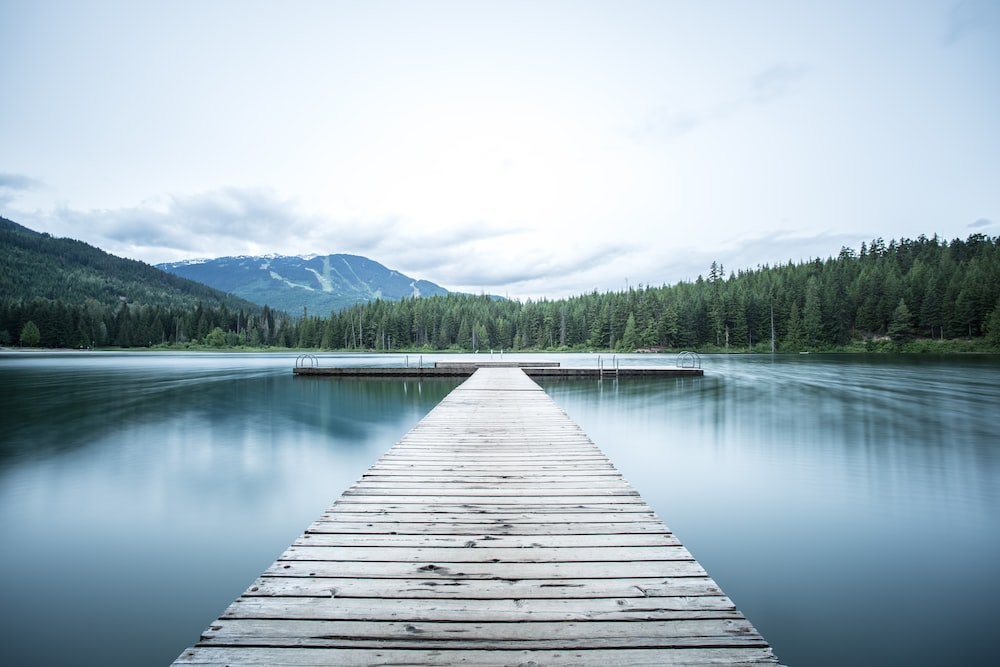

In [11]:
import requests
from PIL import Image
from io import BytesIO


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


image_file = "https://llava-vl.github.io/static/images/view.jpg"

image = load_image(image_file)
image_tensor = image_processor.preprocess(image, return_tensors="pt")["pixel_values"]

text_message = "What are the things I should be cautious about when I visit here?"
print(f"Question: {text_message}")
image

### Test model inference
[back to top ⬆️](#Table-of-contents:)

Generation process for long response maybe time consuming, for accessing partial result as soon as it is generated without waiting when whole process finished, Streaming API can be used. Token streaming is the mode in which the generative system returns the tokens one by one as the model generates them. This enables showing progressive generations to the user rather than waiting for the whole generation. Streaming is an essential aspect of the end-user experience as it reduces latency, one of the most critical aspects of a smooth experience. You can find more details about how streaming work in [HuggingFace documentation](https://huggingface.co/docs/text-generation-inference/conceptual/streaming).

Also for simplification of preparing input in conversational mode, we will use Conversation Template helper provided by model authors for accumulating history of provided messages and images.

In [12]:
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.constants import IMAGE_TOKEN_INDEX
from transformers import TextStreamer
from llava.conversation import conv_templates, SeparatorStyle

# Prepare 
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
conv_mode = "mpt"

conv = conv_templates[conv_mode].copy()
roles = ("user", "assistant")

if mm_use_im_start_end:
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + "\n" + text_message
else:
    inp = DEFAULT_IMAGE_TOKEN + "\n" + text_message
conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)

prompt = conv.get_prompt()
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0)
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
print("Answer:")

output_ids = ov_model.generate(
    input_ids,
    images=image_tensor,
    do_sample=True,
    temperature=0.2,
    max_new_tokens=1024,
    streamer=streamer,
    use_cache=True,
    stopping_criteria=[stopping_criteria],
)

Answer:
When visiting this location, I should be cautious about the water level and the presence of boats. The image shows a dock with a boat in the water, and the water appears to be relatively shallow. It is essential to be mindful of the water depth when approaching the dock, as it could be dangerous to step into the water without checking the water level. Additionally, I should be aware of the boats in the water, as they could pose a risk if they are not properly secured or if they are not being used as intended. It is crucial to maintain a safe distance from the boats and follow any posted signs or guidelines to ensure a safe and enjoyable experience.


## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
import gradio as gr
from threading import Event, Thread
from transformers import TextIteratorStreamer

title_markdown = ("""
# 🌋 LLaVA: Large Language and Vision Assistant
""")

tos_markdown = ("""
### Terms of use
By using this service, users are required to agree to the following terms:
The service is a research preview intended for non-commercial use only. It only provides limited safety measures and may generate offensive content. It must not be used for any illegal, harmful, violent, racist, or sexual purposes. The service may collect user dialogue data for future research.
""")

conv = conv_templates[conv_mode].copy()
conv.messages = []


def clear_history(textbox, imagebox, chatbot):
    """
    callback function for clearing chat windows in interface on clear button click
    
    Params:
      textbox: current textbox for user messages state
      imagebox: current imagebox state
      chatbot: current chatbot state
    Returns:
      empty textbox, imagebox and chatbot states
    """
    conv.messages = []
    
    return None, None, None

def user(message, history):
    """
    callback function for updating user messages in interface on submit button click
    
    Params:
      message: current message
      history: conversation history
    Returns:
      updated message and conversation history
    """
    # Append the user's message to the conversation history
    return "", history + [[message, ""]]

def bot(image, history, temperature=0.2, top_p=0.7, max_new_tokens=1024):
    """
    callback function for running chatbot on submit button click
    
    Params:
      history: conversation history
      temperature:  parameter for control the level of creativity in AI-generated text. 
                    By adjusting the `temperature`, you can influence the AI model's probability distribution, making the text more focused or diverse.
      top_p: parameter for control the range of tokens considered by the AI model based on their cumulative probability.
    
    """
    
    text = history[-1][0]
    if len(text) <= 0 and image is None:
        conv.skip_next = True
        yield history
    text = text[:1536]  # Hard cut-off
    if image is not None:
        text = text[:1200]  # Hard cut-off for images
        if '<image>' not in text:
            text = text + '\n<image>'
        text = (text, image, 'Resize')
    conv.append_message(conv.roles[0], text)
    conv.append_message(conv.roles[1], None)
    conv.skip_next = False

    # Construct the input message string for the model by concatenating the current system message and conversation history
    prompt = conv.get_prompt()
    image = conv.get_images(return_pil=True)
    if not image:
        image_tensor = None
    else:
        image_tensor = image_processor.preprocess(image, return_tensors="pt")["pixel_values"]
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0)
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    # Tokenize the messages string
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    generate_kwargs = dict(
        input_ids=input_ids,
        images=image_tensor,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=temperature > 0.001,
        top_p=top_p,
        streamer=streamer,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )

    stream_complete = Event()

    def generate_and_signal_complete():
        """
        genration function for single thread
        """
        ov_model.generate(**generate_kwargs)
        stream_complete.set()

    t1 = Thread(target=generate_and_signal_complete)
    t1.start()

    # Initialize an empty string to store the generated text
    partial_text = ""
    for new_text in streamer:
        if not new_text: 
            continue
        partial_text += new_text
        conv.messages[-1][-1] = partial_text
        history[-1][1] = partial_text
        yield history

with gr.Blocks(title="LLaVA") as demo:
    gr.Markdown(title_markdown)

    with gr.Row():
        with gr.Column():
            imagebox = gr.Image(type="pil")
            with gr.Accordion("Parameters", open=False, visible=True) as parameter_row:
                temperature = gr.Slider(minimum=0.0, maximum=1.0, value=0.2, step=0.1, interactive=True, label="Temperature",)
                top_p = gr.Slider(minimum=0.0, maximum=1.0, value=0.7, step=0.1, interactive=True, label="Top P",)
                max_output_tokens = gr.Slider(minimum=0, maximum=1024, value=512, step=64, interactive=True, label="Max output tokens",)

        with gr.Column(scale=3):
            with gr.Column(scale=6):
                chatbot = gr.Chatbot(height=400)
                with gr.Row():
                    with gr.Column(scale=8):
                        textbox = gr.Textbox(show_label=False, placeholder="Enter text and press ENTER", visible=True, container=False)
                    with gr.Column(scale=1, min_width=60):
                        submit_btn = gr.Button(value="Submit", visible=True)
                with gr.Row(visible=True) as button_row:
                    clear_btn = gr.Button(value="🗑️  Clear history", interactive=True)

    gr.Markdown(tos_markdown)

            
    submit_event = textbox.submit(
        fn=user,
        inputs=[textbox, chatbot],
        outputs=[textbox, chatbot],
        queue=False,
    ).then(
        bot, [imagebox, chatbot, temperature, top_p, max_output_tokens], chatbot, queue=True
    )
    # Register listeners
    clear_btn.click(clear_history, [textbox, imagebox, chatbot], [chatbot, textbox, imagebox])
    submit_click_event = submit_btn.click(
        fn=user,
        inputs=[textbox, chatbot],
        outputs=[textbox, chatbot],
        queue=False,
    ).then(bot, [imagebox, chatbot, temperature, top_p, max_output_tokens], chatbot, queue=True)

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
try:
    demo.queue(max_size=2).launch(debug=True)
except Exception:
    demo.queue(max_size=2).launch(share=True, debug=True)